In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import shutil
import random
import pandas as pd 
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# Deep learning libraries
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Setting seeds for reproducibility
seed = 232
np.random.seed(seed)
#tensorflow..set_random_seed(seed)

In [ ]:
!pip install split_folders

In [ ]:
root_dir = '/content/drive/MyDrive/ Radiography Database/'

In [ ]:
import splitfolders 
splitfolders.ratio(root_dir, output="output", seed=1337, ratio=(.8, 0.1,0.1))

Copying files: 2695 files [26:38,  1.69 files/s]


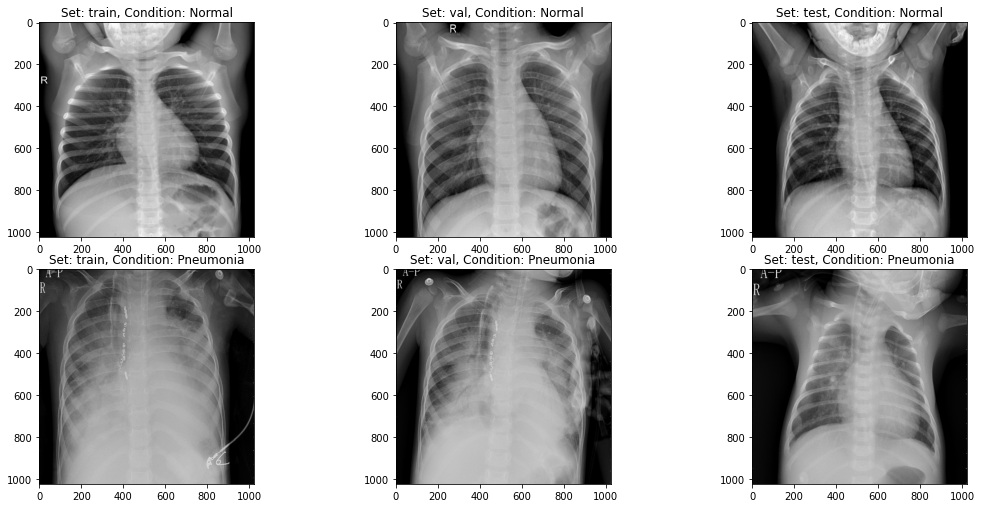

In [ ]:
input_path = '/content/output/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/Viral Pneumonia/'+os.listdir(set_path+'/Viral Pneumonia')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [ ]:
#Distribution of our datasets
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/Viral Pneumonia'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1076, pneumonia images: 1080
Set: val, normal images: 134, pneumonia images: 135
Set: test, normal images: 135, pneumonia images: 135


Viral Pneumonia


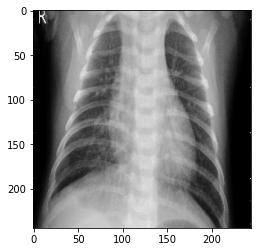

In [ ]:
#visualize data

image_path = root_dir + "Viral Pneumonia/Viral Pneumonia (1024).png"
new_img = image.load_img(image_path, target_size=(244, 244))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
print("Viral Pneumonia")
plt.imshow(new_img)

NORMAL


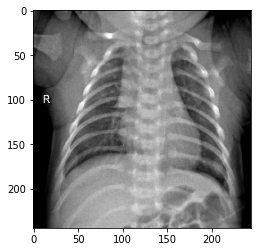

In [ ]:
image_path = root_dir + "NORMAL/NORMAL (1003).png"
new_img = image.load_img(image_path, target_size=(244, 244))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
print("NORMAL")
plt.imshow(new_img)

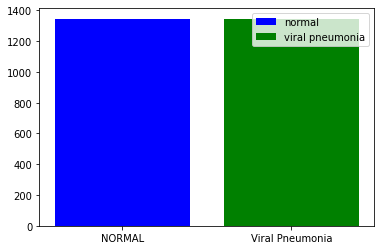

In [ ]:
fig, ax = plt.subplots()

ax.bar("NORMAL",1341,color="b",label="normal")
ax.bar("Viral Pneumonia",1345,color="g",label="viral pneumonia")
ax.legend()

In [ ]:
from PIL import Image

In [ ]:
input_path = '/content/output/'

def process_data(img_dims, batch_size):
    #Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    #This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    val_gen = val_datagen.flow_from_directory(
    directory=input_path+'val', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True) 

    #I will be making predictions off of the test set in one batch size
    #This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/Viral Pneumonia/']:
        for img in (os.listdir(input_path + 'test' + cond)):

            img = image.load_img(input_path+'test'+cond+img, target_size=(150, 150))
            img_tensor = image.img_to_array(img)                   
            img_tensor /= 255.                                     

            if cond=='/NORMAL/':
                label = 0
            elif cond=='/Viral Pneumonia/':
                label = 1
            test_data.append(img_tensor)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    


    
    return train_gen, val_gen, test_data, test_labels    


In [ ]:
# Hyperparameters
img_dims = 150
epochs = 30
batch_size = 32

# Getting the data
train_gen, val_gen  = process_data(img_dims, batch_size)

Found 2155 images belonging to 2 classes.
Found 269 images belonging to 2 classes.


In [ ]:
# Input layer
inputs = Input(shape=(img_dims, img_dims, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Fourth conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fifth conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# FC layer
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.7)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')


In [ ]:
# Fitting the model
hist = model.fit(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=30, validation_data=val_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint,lr_reduce,early_stop])

Epoch 1/30
67/67 [==============================] - 49s 729ms/step - loss: 0.3097 - accuracy: 0.8902 - val_loss: 1.4290 - val_accuracy: 0.4961
Epoch 2/30
67/67 [==============================] - 48s 718ms/step - loss: 0.2783 - accuracy: 0.9077 - val_loss: 2.1081 - val_accuracy: 0.5000
Epoch 3/30
67/67 [==============================] - 48s 716ms/step - loss: 0.2655 - accuracy: 0.9086 - val_loss: 0.7318 - val_accuracy: 0.5039
Epoch 4/30
67/67 [==============================] - ETA: 0s - loss: 0.2637 - accuracy: 0.9114
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
67/67 [==============================] - 48s 717ms/step - loss: 0.2637 - accuracy: 0.9114 - val_loss: 1.7192 - val_accuracy: 0.4922
Epoch 5/30
67/67 [==============================] - 48s 715ms/step - loss: 0.2271 - accuracy: 0.9228 - val_loss: 1.3591 - val_accuracy: 0.4961
Epoch 6/30
67/67 [==============================] - ETA: 0s - loss: 0.2134 - accuracy: 0.9336
Epoch 00006: ReduceLROnPlate

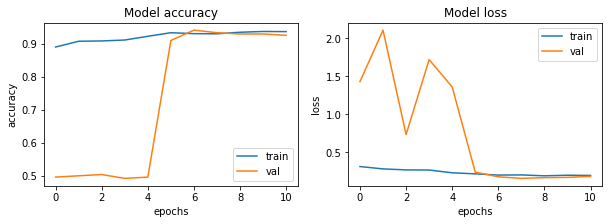

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
model.save('model.h5')

In [ ]:
from keras.models import load_model

In [ ]:
model = load_model('model.h5')

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[131   4]
 [ 16 119]]

TEST METRICS ----------------------
Accuracy: 92.5925925925926%
Precision: 96.7479674796748%
Recall: 88.14814814814815%
F1-score: 92.24806201550389

TRAIN METRIC ----------------------
Train acc: 93.69
